In [1]:
import praw
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import argparse
import os
from typing import List, Dict, Optional
import json
import dotenv
from langchain_anthropic import ChatAnthropic
from langchain.schema import HumanMessage

/Users/benpleasant/Documents/RedditAnalyzer/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
dotenv.load_dotenv(dotenv_path='.env')
client_id = os.environ['reddit_client_id']
client_secret = os.environ['reddit_client_secret']
anthropic_api_key = os.environ['anthropic_api_key']

SUBREDDIT_NAME = "chimefinancial"

In [3]:
def initialize_reddit(client_id, client_secret, user_agent='RedditAnalyzer/1.0'):
    return praw.Reddit(
        client_id=client_id,
        client_secret=client_secret,
        user_agent=user_agent
    )

In [4]:
def fetch_posts(reddit, subreddit_name: str, limit: int = 1000):
    subreddit = reddit.subreddit(subreddit_name)
    posts_data = []
    post_ids = set()

    for post in subreddit.hot(limit=limit//3):
        if post.id not in post_ids:
            posts_data.append({
                'title': post.title,
                'text': post.selftext,
                'score': post.score,
                'num_comments': post.num_comments,
                'created_utc': datetime.fromtimestamp(post.created_utc),
                'id': post.id,
                'url': post.url
            })
            post_ids.add(post.id)

    for post in subreddit.new(limit=limit//3):
        if post.id not in post_ids:
            posts_data.append({
                'title': post.title,
                'text': post.selftext,
                'score': post.score,
                'num_comments': post.num_comments,
                'created_utc': datetime.fromtimestamp(post.created_utc),
                'id': post.id,
                'url': post.url
            })
            post_ids.add(post.id)

    for post in subreddit.top(time_filter='month', limit=limit//3):
        if post.id not in post_ids:
            posts_data.append({
                'title': post.title,
                'text': post.selftext,
                'score': post.score,
                'num_comments': post.num_comments,
                'created_utc': datetime.fromtimestamp(post.created_utc),
                'id': post.id,
                'url': post.url
            })
            post_ids.add(post.id)

    return pd.DataFrame(posts_data)

In [5]:
class RedditLLMAnalyzer:
    def __init__(self, api_key: str, model: str = "claude-3-5-sonnet-20241022"):
        self.llm = ChatAnthropic(
            api_key=api_key,
            model=model,
            temperature=0.3
        )

    def discover_categories(self, posts: List[Dict], subreddit_name: str) -> Dict:

        # Sample posts
        top_posts = sorted(posts, key=lambda x: x['score'], reverse=True)[:15]
        recent_posts = sorted(posts, key=lambda x: x['created_utc'], reverse=True)[:10]
        diverse_posts = top_posts + recent_posts

        posts_text = "\n\n".join([
            f"Post {i+1}:\nTitle: {post['title']}\nContent: {post.get('text', '')[:300]}"
            for i, post in enumerate(diverse_posts[:25])
        ])

        prompt = f"""Analyze these posts from r/{subreddit_name} and discover the natural categories/topics that emerge.

                    Posts:
                    {posts_text}
                    
                    Create a JSON object with:
                    1. "categories": A list of 5-10 category names that naturally emerge from this content
                    2. "category_keywords": A dictionary mapping each category to a list of relevant keywords/phrases
                    3. "community_context": A brief description of what this subreddit is about
                    4. "analysis_dimensions": Suggested analysis types relevant to understanding this community (e.g., "common_questions", "pain_points", "community_dynamics", "popular_topics", etc.)
                    
                    Return ONLY valid JSON, no additional text."""

        response = self.llm.invoke([HumanMessage(content=prompt)])

        try:
            content = response.content
            if '```json' in content:
                content = content.split('```json')[1].split('```')[0]
            elif '```' in content:
                content = content.split('```')[1].split('```')[0]

            return json.loads(content.strip())
        except json.JSONDecodeError:
            return {
                "error": "Failed to parse JSON",
                "raw_response": response.content,
                "categories": [],
                "category_keywords": {},
                "community_context": "Unable to parse",
                "analysis_dimensions": []
            }

    def categorize_posts(self, posts: List[Dict], categories: Dict, subreddit_name: str) -> Dict:

        category_keywords = categories.get('category_keywords', {})

        posts_sample = sorted(posts, key=lambda x: x['score'] + x['num_comments'], reverse=True)[:30]

        posts_text = "\n\n".join([
            f"Post {i+1} (ID: {i}):\nTitle: {post['title']}\nContent: {post.get('text', '')[:200]}"
            for i, post in enumerate(posts_sample)
        ])

        categories_list = list(category_keywords.keys())

        prompt = f"""Given these categories for r/{subreddit_name}:
                    {json.dumps(categories_list, indent=2)}
                    
                    Categorize each post below. Each post can belong to multiple categories.
                    
                    Posts:
                    {posts_text}
                    
                    For each post ID (0-{len(posts_sample)-1}), return which categories it belongs to.
                    Also identify the overall sentiment (positive/negative/neutral/mixed) distribution across posts.
                    
                    Return as JSON with this structure:
                    {{
                        "post_categories": {{"0": ["Category1", "Category2"], "1": [...], ...}},
                        "sentiment_breakdown": {{"positive": X, "negative": Y, "neutral": Z, "mixed": W}}
                    }}
                    
                    Return ONLY valid JSON."""

        response = self.llm.invoke([HumanMessage(content=prompt)])

        try:
            content = response.content
            if '```json' in content:
                content = content.split('```json')[1].split('```')[0]
            elif '```' in content:
                content = content.split('```')[1].split('```')[0]

            categorization = json.loads(content.strip())

            # Map back to actual posts
            categorization['posts_sample'] = posts_sample

            return categorization
        except json.JSONDecodeError:
            return {
                "error": "Failed to parse categorization",
                "raw_response": response.content
            }

    def analyze_by_dimension(self, posts: List[Dict], dimension: str, subreddit_name: str, context: str = "") -> str:

        top_posts = sorted(posts, key=lambda x: x['score'] + x['num_comments'], reverse=True)[:20]

        posts_text = "\n\n".join([
            f"Post {i+1}:\nTitle: {post['title']}\nContent: {post.get('text', '')[:400]}\nScore: {post['score']}, Comments: {post['num_comments']}"
            for i, post in enumerate(top_posts)
        ])

        dimension_prompts = {
            "common_questions": f"""Identify the most common questions and topics people ask about in r/{subreddit_name}.
                                - What are people trying to learn?
                                - What confuses them?
                                - What help are they seeking?""",
                                
            "pain_points": f"""Identify the main pain points and frustrations expressed in r/{subreddit_name}.
                                - What problems are people facing?
                                - What complaints are common?
                                - What challenges do they discuss?""",
                                
            "community_dynamics": f"""Analyze the community dynamics and culture of r/{subreddit_name}.
                                - How do members interact?
                                - What's the tone and atmosphere?
                                - What are the community norms?
                                - How supportive are members to each other?""",
                                
            "popular_topics": f"""Identify trending and popular topics in r/{subreddit_name}.
                                - What generates the most engagement?
                                - What topics keep coming up?
                                - What interests the community most?""",
                                
            "user_sentiment": f"""Analyze the overall sentiment and emotions in r/{subreddit_name}.
                                - What's the general mood?
                                - Are people satisfied or frustrated?
                                - What creates positive vs negative reactions?"""
        }
                                
        base_prompt = dimension_prompts.get(dimension, f"Analyze these posts from r/{subreddit_name} to understand: {dimension}")

        full_prompt = f"""{base_prompt}
                                
                            Context: {context}
                            
                            Posts:
                            {posts_text}
                            
                            Provide a clear analysis focused on understanding the community, not on making business recommendations."""

        response = self.llm.invoke([HumanMessage(content=full_prompt)])
        return response.content

    def generate_community_summary(self, subreddit_name: str, categories: Dict,
                                   categorization: Dict, analyses: Dict, stats: Dict) -> str:

        analyses_text = "\n\n".join([
            f"=== {key.upper().replace('_', ' ')} ===\n{value}"
            for key, value in analyses.items()
        ])

        prompt = f"""Create a summary to help someone understand the r/{subreddit_name} community based on this analysis.

                    COMMUNITY CONTEXT:
                    {categories.get('community_context', 'N/A')}
                    
                    DISCOVERED CATEGORIES:
                    {json.dumps(categories.get('categories', []), indent=2)}
                    
                    DATASET STATISTICS:
                    - Total posts analyzed: {stats['total_posts']}
                    - Date range: {stats['date_range']}
                    - Average engagement: {stats['avg_score']:.1f} score, {stats['avg_comments']:.1f} comments
                    
                    SENTIMENT:
                    {json.dumps(categorization.get('sentiment_breakdown', {}), indent=2)}
                    
                    DETAILED ANALYSES:
                    {analyses_text}
                    
                    Create a summary with:
                    1. **Community Overview** - What is this community about and who participates?
                    2. **Main Discussion Topics** - What do people talk about most?
                    3. **Community Atmosphere** - What's the general mood and culture?
                    4. **Common Themes** - What patterns and recurring topics emerge?
                    5. **Notable Insights** - Interesting observations about this community
                    
                    Write this as an external observer trying to understand the community, not as an internal stakeholder."""

        response = self.llm.invoke([HumanMessage(content=prompt)])
        return response.content

In [6]:
def create_visualizations(df_posts, categories_info, categorization):
    
    # Configure style
    sns.set_style('whitegrid')
    plt.rcParams['figure.figsize'] = (12, 6)
    plt.rcParams['font.family'] = 'DejaVu Sans'

    # Top posts by engagement
    top_posts = df_posts.nlargest(15, 'score')

    plt.figure(figsize=(14, 8))
    plt.barh(range(len(top_posts)), top_posts['score'].values)
    clean_titles = [
        ''.join(char for char in title if ord(char) < 0x10000)[:50] + ('...' if len(title) > 50 else '')
        for title in top_posts['title'].values
    ]
    plt.yticks(range(len(top_posts)), clean_titles)
    plt.xlabel('Score')
    plt.title('Top 15 Posts by Score')
    plt.tight_layout()
    plt.show()

    # Sentiment breakdown
    if 'sentiment_breakdown' in categorization:
        sentiment = categorization['sentiment_breakdown']
        plt.figure(figsize=(8, 6))
        plt.pie(sentiment.values(), labels=sentiment.keys(), autopct='%1.1f%%', startangle=90)
        plt.title('Sentiment Distribution')
        plt.axis('equal')
        plt.show()

    # Engagement over time
    df_posts_copy = df_posts.copy()
    df_posts_copy['date'] = pd.to_datetime(df_posts_copy['created_utc']).dt.date
    engagement_by_date = df_posts_copy.groupby('date').agg({
        'score': 'sum',
        'num_comments': 'sum',
        'id': 'count'
    }).rename(columns={'id': 'post_count'})

    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Post Count', color='tab:blue')
    ax1.plot(engagement_by_date.index, engagement_by_date['post_count'],
             color='tab:blue', marker='o', label='Posts')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Total Score', color='tab:red')
    ax2.plot(engagement_by_date.index, engagement_by_date['score'],
             color='tab:red', marker='s', label='Score')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    plt.title('Posting Activity and Engagement Over Time')
    fig.tight_layout()
    plt.show()

In [7]:
reddit = initialize_reddit(client_id, client_secret)

In [8]:
df_posts = fetch_posts(reddit, SUBREDDIT_NAME, limit=1000)

In [9]:
analyzer = RedditLLMAnalyzer(anthropic_api_key)

In [10]:
posts_list = df_posts.to_dict('records')
categories = analyzer.discover_categories(posts_list, SUBREDDIT_NAME)

In [11]:
print(f"\n✓ Discovered {len(categories.get('categories', []))} categories:")
for cat in categories.get('categories', []):
    print(f"  - {cat}")

print(f"\n✓ Community context: {categories.get('community_context', 'N/A')}")

# Display categories in detail
print("\n" + "="*80)
print("DISCOVERED CATEGORIES & KEYWORDS")
print("="*80)
for category, keywords in categories.get('category_keywords', {}).items():
    print(f"\n{category}:")
    print(f"  Keywords: {', '.join(keywords)}")

# Categorize posts
print("\n" + "="*80)
print("CATEGORIZING POSTS")
print("="*80)
categorization = analyzer.categorize_posts(posts_list, categories, SUBREDDIT_NAME)

# Display categorization results
print("\nSentiment Breakdown:")
for sentiment, count in categorization.get('sentiment_breakdown', {}).items():
    print(f"  {sentiment.capitalize()}: {count}")

# Dimensional analyses
print("\n" + "="*80)
print("ANALYZING COMMUNITY")
print("="*80)

analysis_dimensions = categories.get('analysis_dimensions', [
    'common_questions', 'pain_points', 'community_dynamics', 'popular_topics'
])

analyses = {}
context = categories.get('community_context', '')

for i, dimension in enumerate(analysis_dimensions[:5], 1):
    print(f"\n[{i}/{min(len(analysis_dimensions), 5)}] Analyzing: {dimension}...")
    analyses[dimension] = analyzer.analyze_by_dimension(
        posts_list[:40],
        dimension,
        SUBREDDIT_NAME,
        context
    )
    # Display each analysis as it completes
    print("\n" + "-"*80)
    print(f"{dimension.upper().replace('_', ' ')}")
    print("-"*80)
    print(analyses[dimension])

# Generate community summary
print("\n" + "="*80)
print("GENERATING COMMUNITY SUMMARY")
print("="*80)

stats = {
    'total_posts': len(df_posts),
    'date_range': f"{df_posts['created_utc'].min()} to {df_posts['created_utc'].max()}",
    'avg_score': df_posts['score'].mean(),
    'avg_comments': df_posts['num_comments'].mean()
}

community_summary = analyzer.generate_community_summary(
    SUBREDDIT_NAME,
    categories,
    categorization,
    analyses,
    stats
)

# Display summary
print("\n" + "="*80)
print("COMMUNITY SUMMARY")
print("="*80)
print(community_summary)


✓ Discovered 8 categories:
  - Card Features
  - Direct Deposits & Payments
  - Loans & Credit
  - Security & Fraud
  - Account Management
  - Customer Experience
  - Benefits & Rewards
  - Technical Issues

✓ Community context: A subreddit for users of Chime, a digital banking platform, where members discuss features, share experiences, ask questions about services, and report issues. The community appears to be particularly active around payment dates and new feature releases.

DISCOVERED CATEGORIES & KEYWORDS

Card Features:
  Keywords: metal card, new cards, card design, debit card, card benefits

Direct Deposits & Payments:
  Keywords: SSI, SSDI, direct deposit, student disbursements, payment delays

Loans & Credit:
  Keywords: Instant Loan, MyPay, SpotMe, interest rate, loan terms, credit check

Security & Fraud:
  Keywords: scam, fraud, security, hacked account, fraud department

Account Management:
  Keywords: balance, account closure, name change, referral bonus, account setu

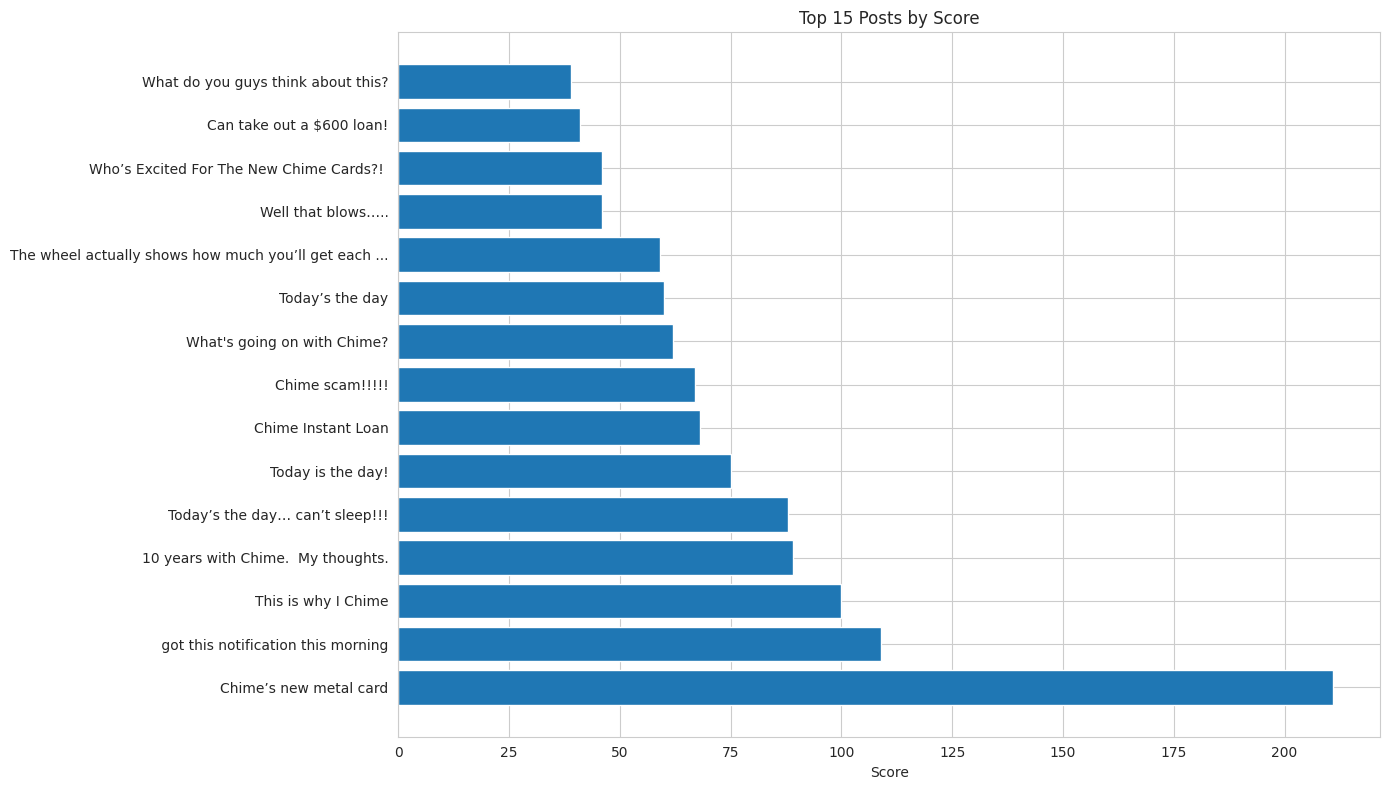

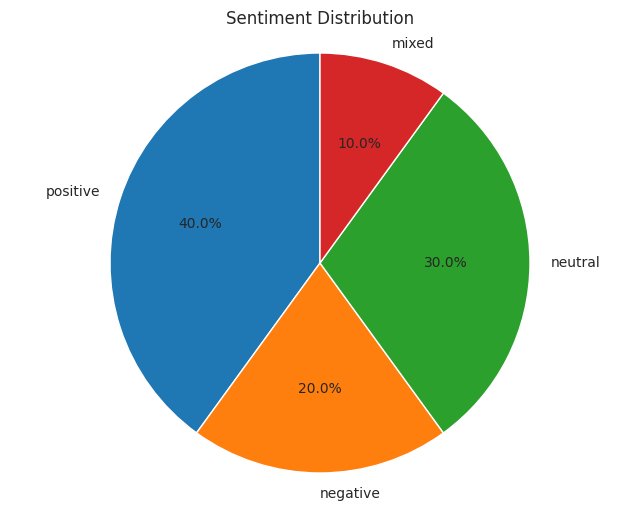

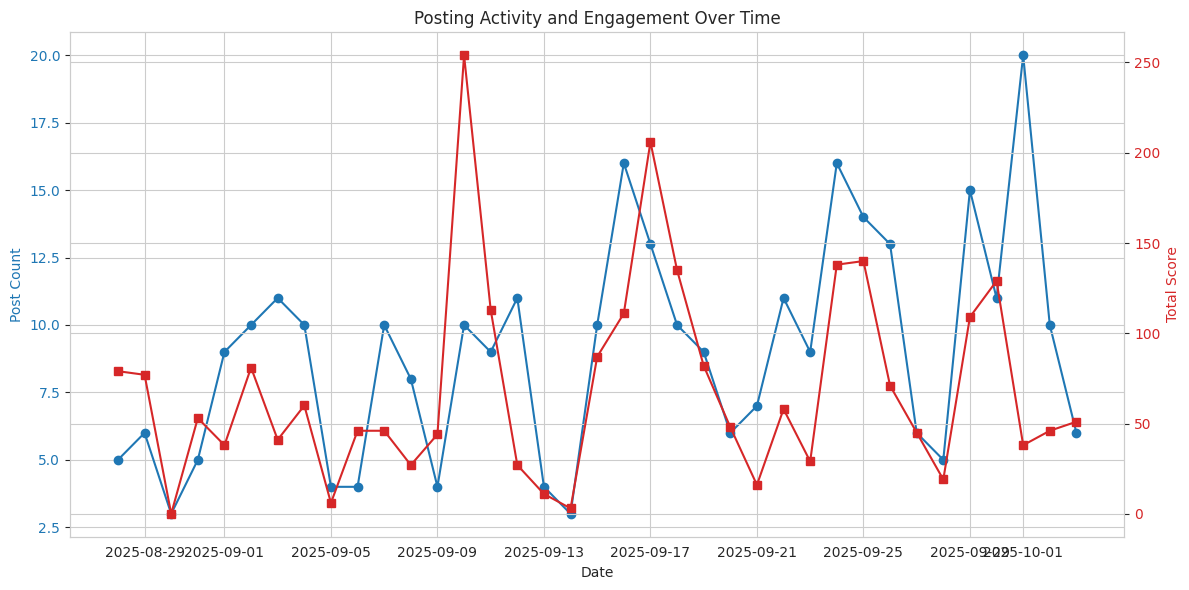

In [12]:
# Create visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.family'] = 'DejaVu Sans'
create_visualizations(df_posts, categories, categorization)


VISUALIZATIONS


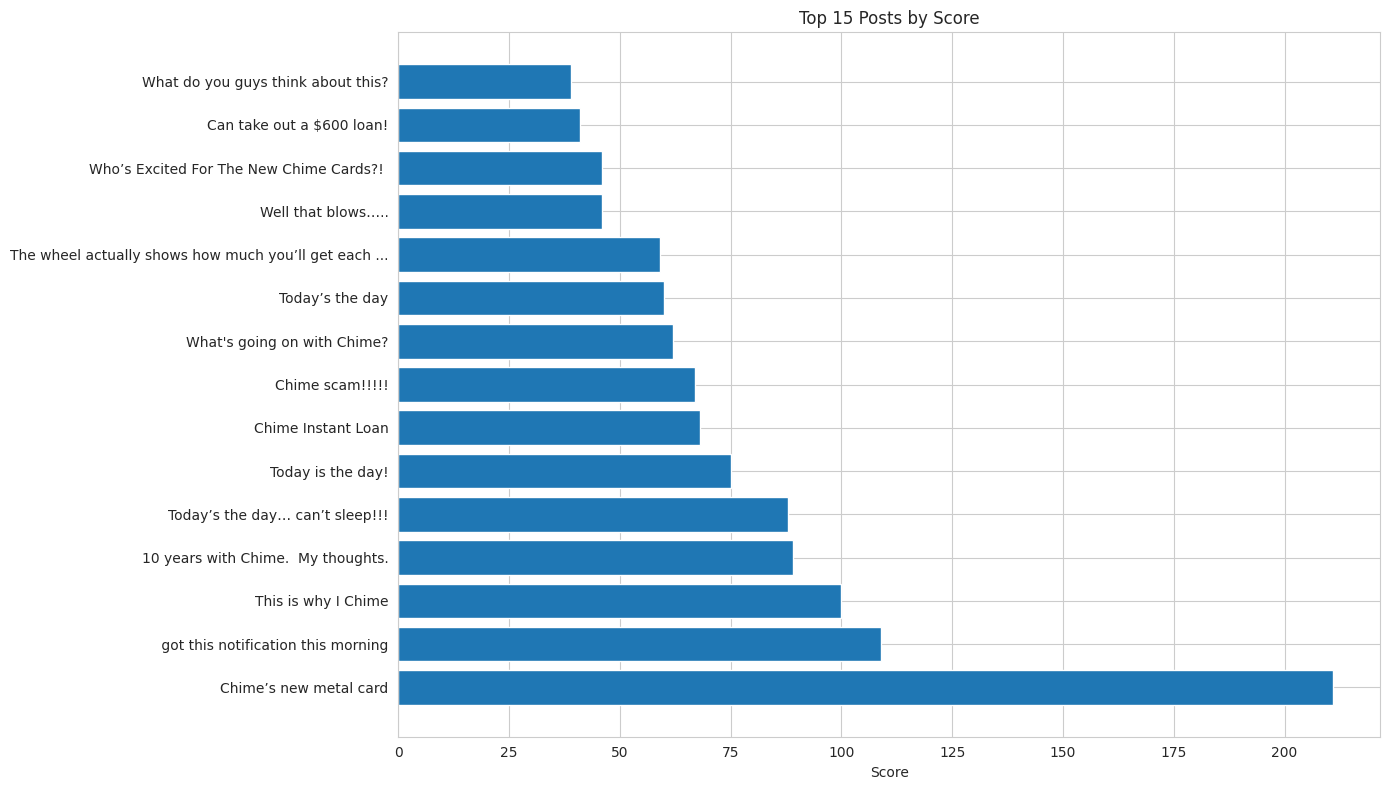

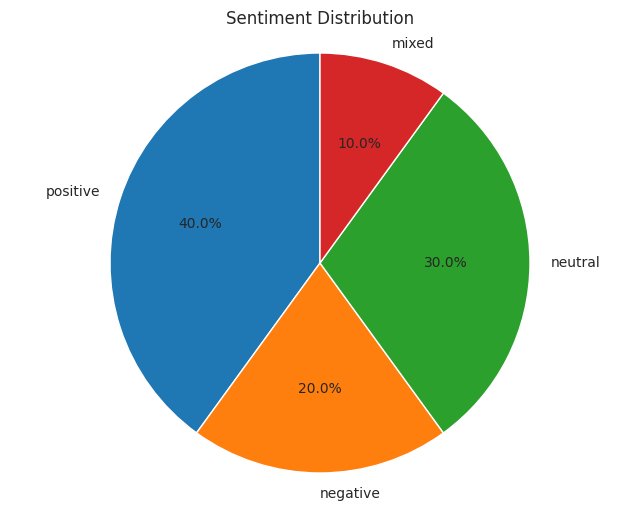

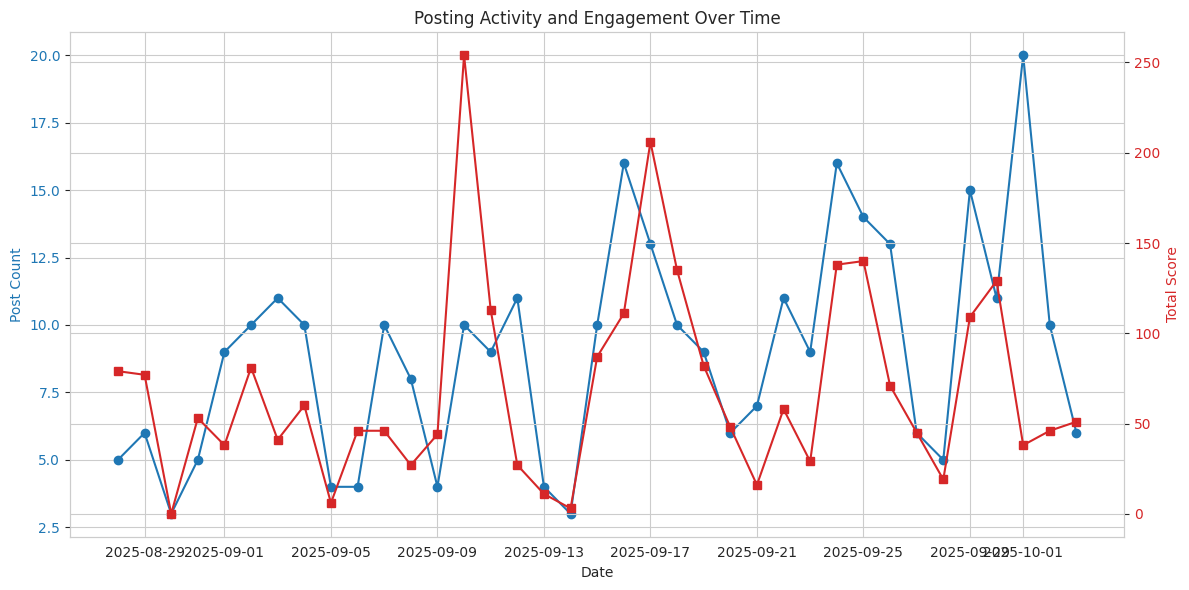


ANALYSIS COMPLETE

Analyzed r/chimefinancial - 333 posts


In [13]:
# Display visualizations
print("\n" + "="*80)
print("VISUALIZATIONS")
print("="*80)
create_visualizations(df_posts, categories, categorization)

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)
print(f"\nAnalyzed r/{SUBREDDIT_NAME} - {len(df_posts)} posts")